# Data Generated Analysis

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

GENERATED_ROOT_PATH = os.path.join("..", "input", "bugnet")
GENERATED_PAIRS_PATH = os.path.join(GENERATED_ROOT_PATH, "generated_pairs.csv")
CODEX_PAIRS_PATH = os.path.join(GENERATED_ROOT_PATH, "codex_results.csv")

In [2]:
df = pd.read_csv(GENERATED_PAIRS_PATH)

df.head()

,problem_id,language,original_status,original_src,changed_src,change,i1,i2,j1,j2,error
0,p00001,C++,Runtime Error,"#include <stdio.h>\nint main(void) {\n int i,...","#include <stdio.h>\nint main(void) {\n int i,...",insert,103,103,103,104,-11
1,p00001,C++,Runtime Error,#include <stdio.h>\n\nint main() {\n int heig...,#include <stdio.h>\n\nint main() {\n int heig...,insert,123,123,123,124,-11
2,p00001,C++,Time Limit Exceeded,#include <algorithm>\n#include <iostream>\n#in...,#include <algorithm>\n#include <iostream>\n#in...,replace,262,263,262,263,TLE
3,p00001,C++,Runtime Error,#include <algorithm>\n#include <iostream>\n\nu...,#include <algorithm>\n#include <iostream>\n\nu...,replace,204,206,204,206,-11
4,p00001,C++,Time Limit Exceeded,#include <algorithm>\n#include <bitset>\n#incl...,#include <algorithm>\n#include <bitset>\n#incl...,replace,611,629,611,619,TLE


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35331 entries, 0 to 35330
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   problem_id       35331 non-null  object
 1   language         35331 non-null  object
 2   original_status  35331 non-null  object
 3   original_src     35331 non-null  object
 4   changed_src      35331 non-null  object
 5   change           35331 non-null  object
 6   i1               35331 non-null  int64 
 7   i2               35331 non-null  int64 
 8   j1               35331 non-null  int64 
 9   j2               35331 non-null  int64 
 10  error            35331 non-null  object
dtypes: int64(4), object(7)
memory usage: 3.0+ MB


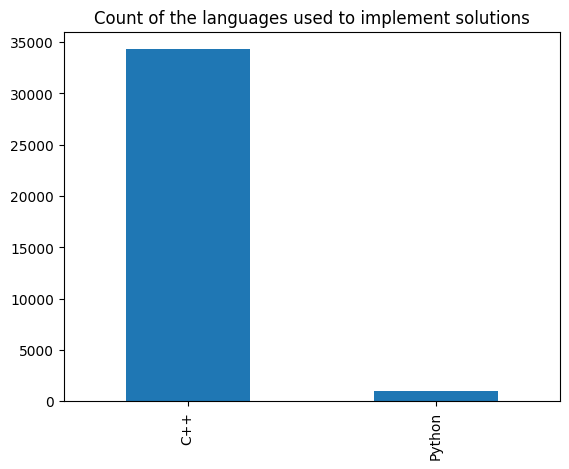

In [4]:
df["language"].value_counts().plot.bar()

plt.title("Count of the languages used to implement solutions")
plt.show()

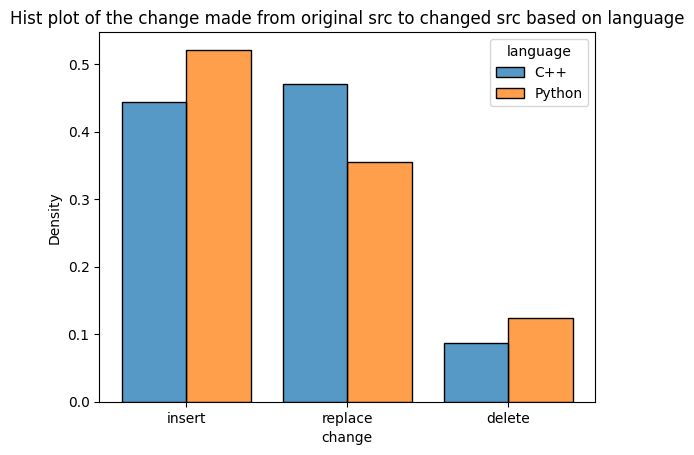

change
language change         
C++      delete     2980
         insert    15202
         replace   16119
Python   delete      127
         insert      537
         replace     366

In [5]:
sns.histplot(x=df["change"], hue=df["language"], multiple="dodge", 
             stat="density", shrink=0.8, common_norm=False)

plt.title("Hist plot of the change made from original src to changed src based on language")
plt.show()

df.groupby(["language", "change"]).agg({"change": "count"})

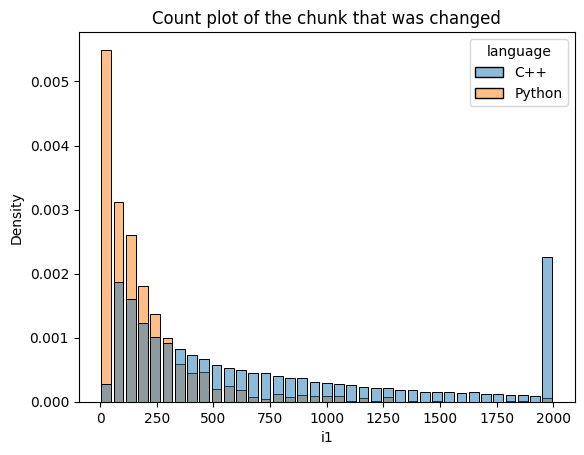

In [10]:
x = df["i1"].map(lambda line: line if line < 2000 else 2000)
sns.histplot(x=x, hue=df["language"], stat="density", shrink=0.8, common_norm=False)

plt.title("Count plot of the chunk that was changed")
plt.show()

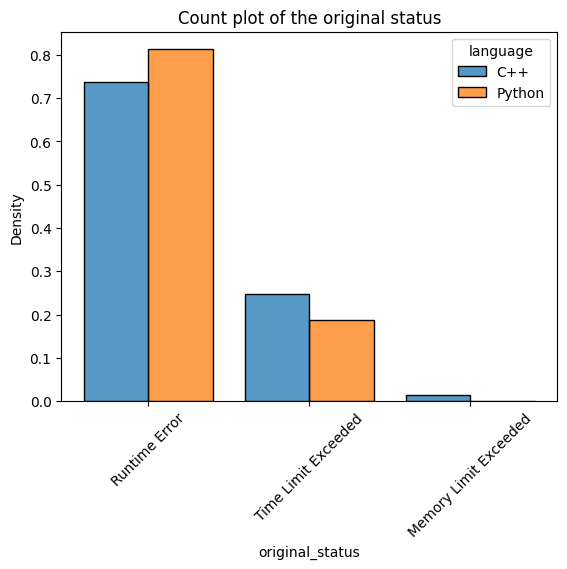

original_status
language original_status                       
C++      Memory Limit Exceeded              492
         Runtime Error                    25300
         Time Limit Exceeded               8509
Python   Runtime Error                      837
         Time Limit Exceeded                193

In [11]:
sns.histplot(x=df["original_status"], hue=df["language"], multiple="dodge", 
             stat="density", shrink=0.8, common_norm=False)

plt.title("Count plot of the original status")
plt.xticks(rotation=45)
plt.show()

df.groupby(["language", "original_status"]).agg({"original_status": "count"})